In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib.patches import Circle
from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler

from plato.visualisation import (
    FigureProcessor,
    set_plot_defaults,
    get_palette,
    adjust_legend,
)

In [2]:
field = "all_sky"

In [3]:
set_plot_defaults()

figure_directory = f"../figures/04_stellar_sample/{field}"
save = True

In [4]:
data = pd.read_csv(f"../data/processed/{field}_targets.csv", low_memory=False)

# filter for FGK stars and remove 0 mass or radius
data = data[data["Stellar Type"] == "FGK"]
data = data[(data["Radius"] > 0) & (data["Mass"] > 0)]

## COORDINATES

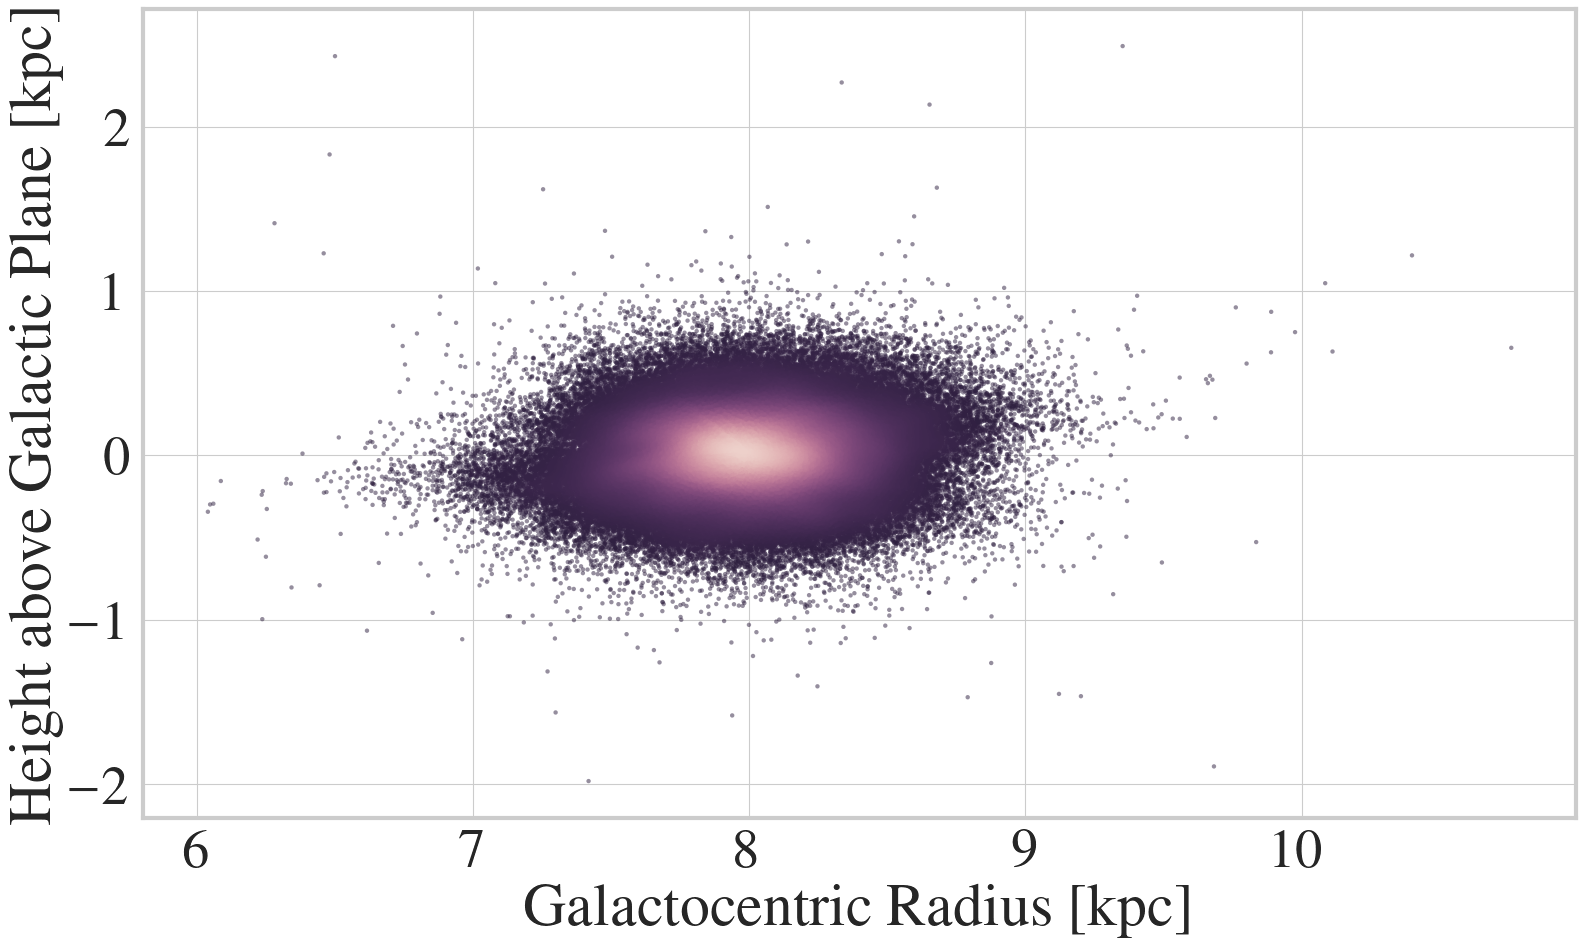

In [9]:
kernel = gaussian_kde(data[["R", "Z"]].sample(n=10000).T)(data[["R", "Z"]][::10].T)
coordinate_scatterplot = sns.scatterplot(
    data=data[::10].assign(
        Population=data["Population"].replace(
            "Thick Disk Candidate",
            "Thick Disk C.",
        )
    ),
    x="R",
    y="Z",
    c=kernel,
    cmap=get_palette(as_cmap=True, reverse=True),
    s=10,
    alpha=0.5,
    linewidth=0,
    rasterized=True,
)

coordinate_scatterplot.set_xlabel("Galactocentric Radius [kpc]")
coordinate_scatterplot.set_ylabel("Height above Galactic Plane [kpc]")

FigureProcessor(coordinate_scatterplot).save(
    "coordinate_scatterplot.pdf",
    figure_directory=figure_directory,
    save=save,
)

## TOOMRE DIAGRAM

/home/chris/Documents/Projects/plato/plato/visualisation/utilities.py:221: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(path, bbox_inches="tight", pad_inches=0)
/home/chris/mambaforge/envs/plato/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/chris/mambaforge/envs/plato/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


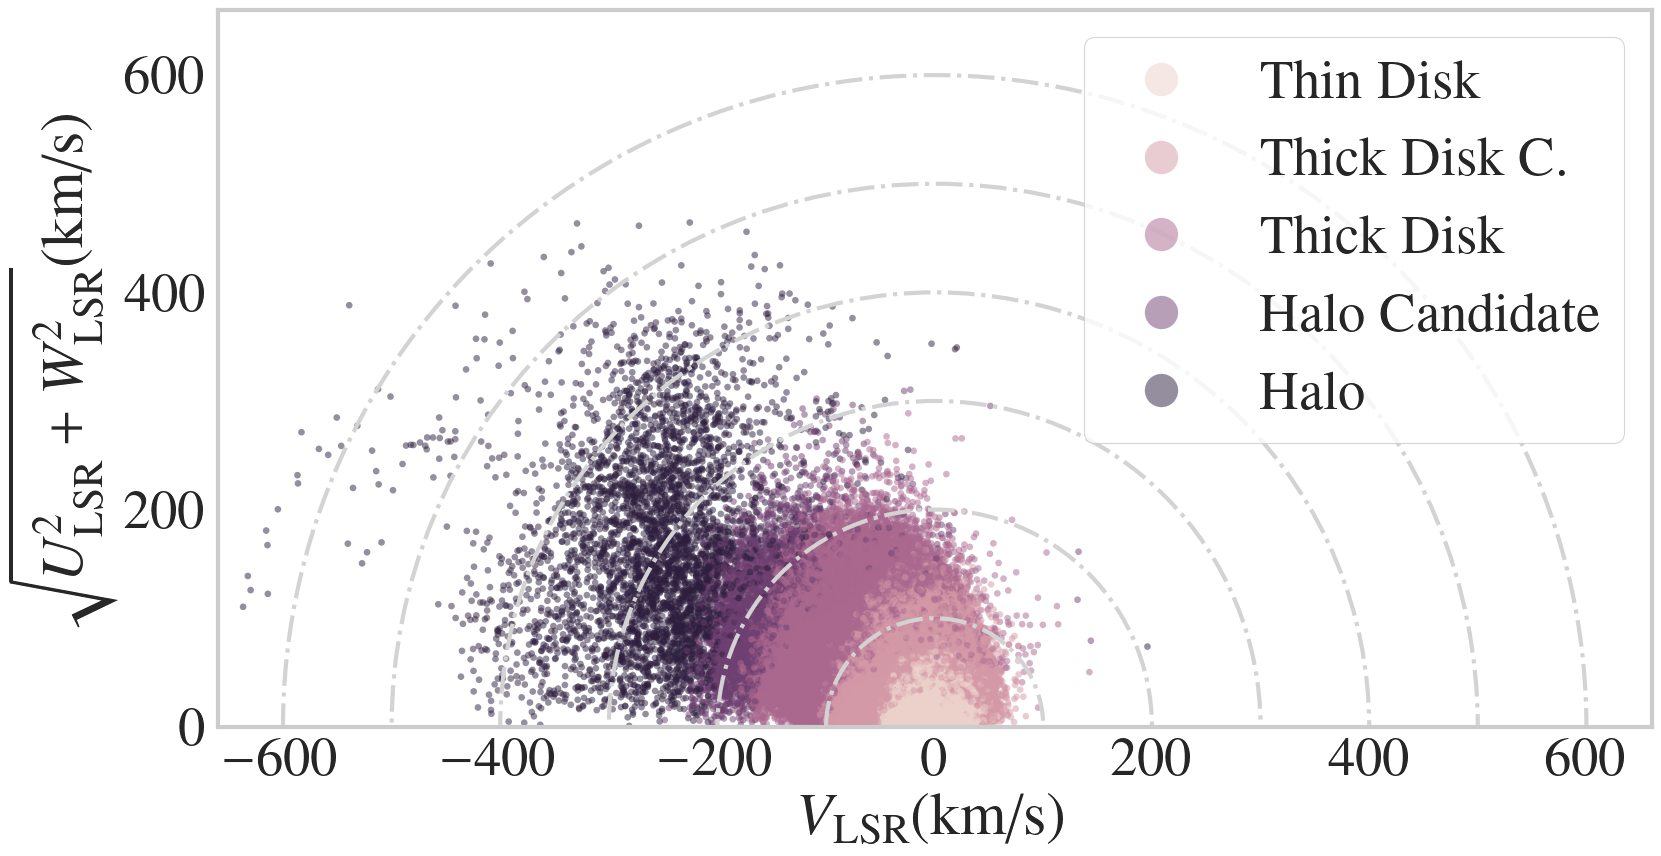

In [15]:
toomre_scatterplot = sns.scatterplot(
    data=data.assign(
        Population=data["Population"].replace(
            "Thick Disk Candidate",
            "Thick Disk C.",
        )
    ),
    x="V",
    y="UW",
    hue="Population",
    palette=get_palette(n_colors=5),
    alpha=0.5,
    linewidth=0,
    rasterized=True,
)
toomre_scatterplot.set_xlim(-660, 660)
toomre_scatterplot.set_ylim(0, 660)

for radius in (100, 200, 300, 400, 500, 600):
    circle = Circle(
        (0, 0),
        radius,
        color="lightgrey",
        linestyle="-.",
        linewidth=3,
        fill=False,
    )
    toomre_scatterplot.add_patch(circle)
toomre_scatterplot.set_aspect("equal")

toomre_scatterplot.grid(False)
toomre_scatterplot.legend(markerscale=5)
toomre_scatterplot.set_xlabel(r"$V_\mathrm{LSR} $(km/s)")
toomre_scatterplot.set_ylabel(r"$\sqrt{U_\mathrm{LSR}^2 + W_\mathrm{LSR}^2} $(km/s)")

FigureProcessor(toomre_scatterplot).save(
    "toomre_scatterplot.pdf",
    figure_directory=figure_directory,
    save=save,
)

## METALLICITY

In [5]:
# fill nan values in [Fe/H]_apogee with [Fe/H]_galah if available
data["[Fe/H]_high_res"] = data["[Fe/H]_apogee"].fillna(data["[Fe/H]_galah"])

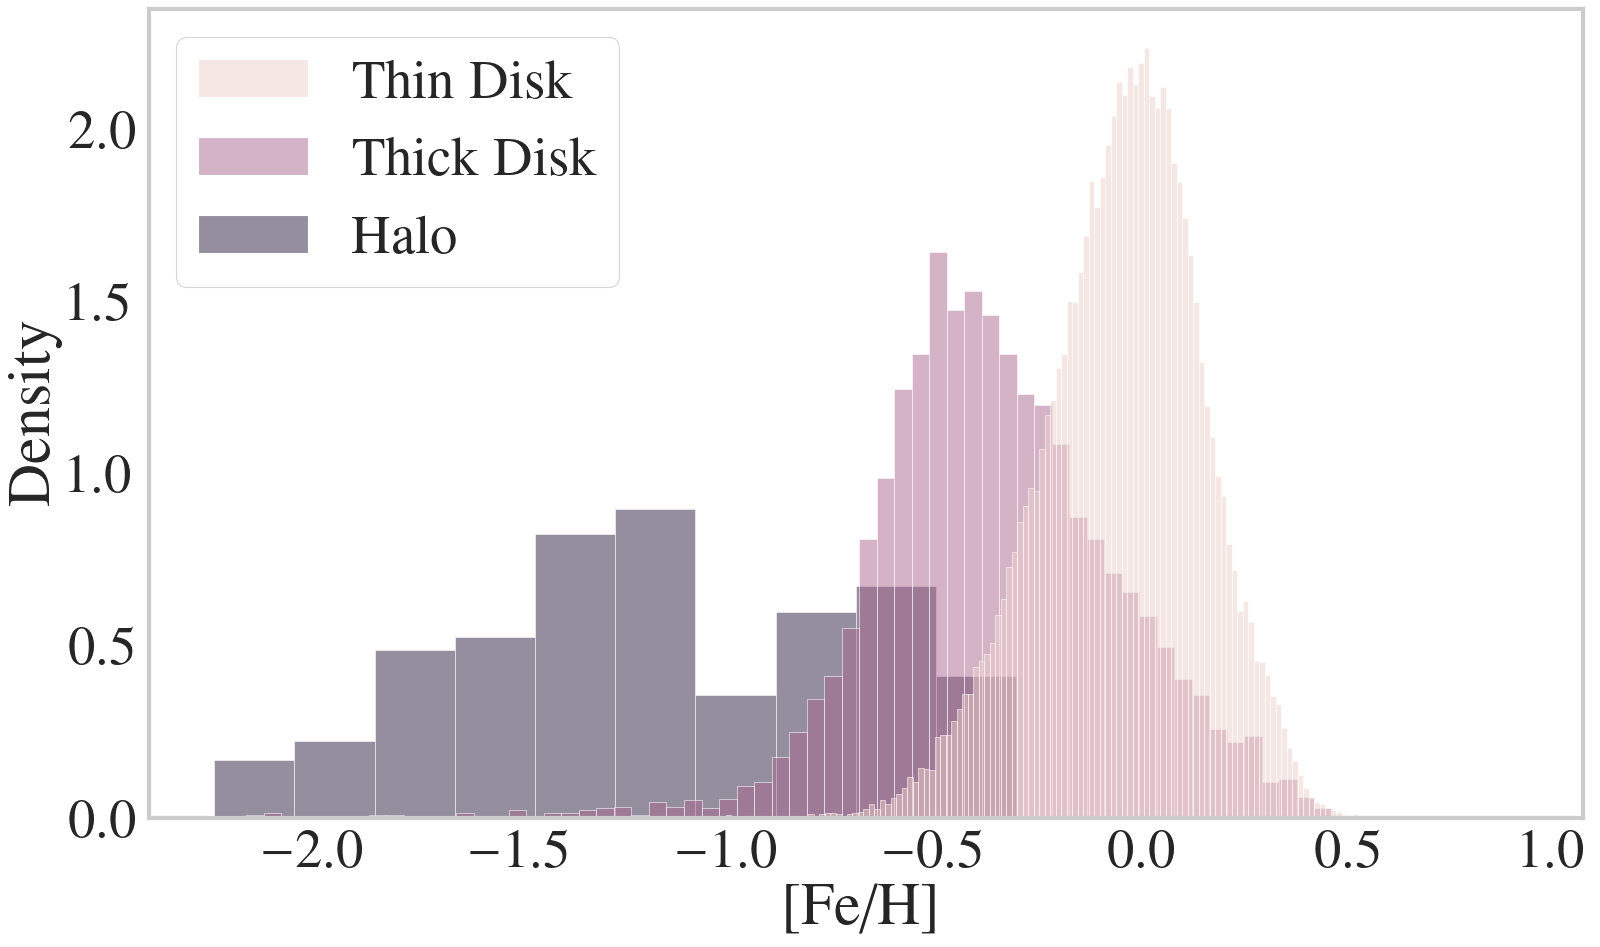

In [6]:
metallicity_plot = sns.histplot(
    data=data,
    x="[Fe/H]_high_res",
    hue="Population",
    hue_order=["Thin Disk", "Thick Disk", "Halo"],
    stat="density",
    common_bins=False,
    common_norm=False,
    palette=get_palette(n_colors=3),
    legend=True,
)
metallicity_plot.get_legend().set_title("")
metallicity_plot.set_xlabel("[Fe/H]")
metallicity_plot.grid(False)

FigureProcessor(metallicity_plot).save(
    "metallicity_hist.pdf",
    figure_directory=figure_directory,
    save=save,
)

## METALLICITY - ALPHA ABUNDANCE

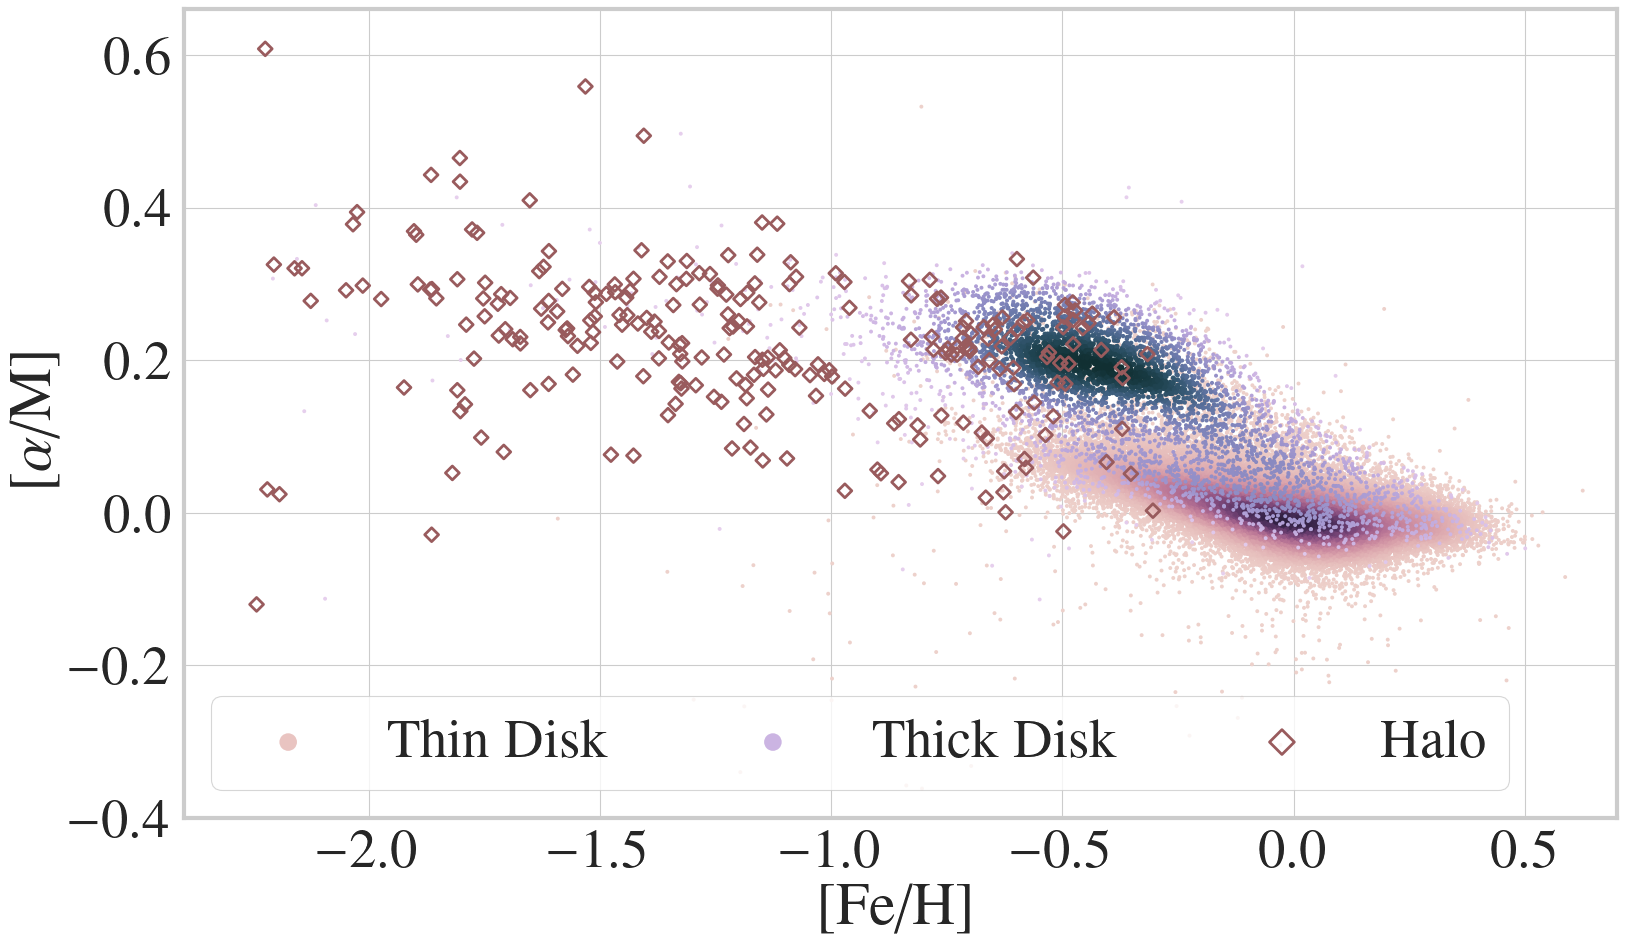

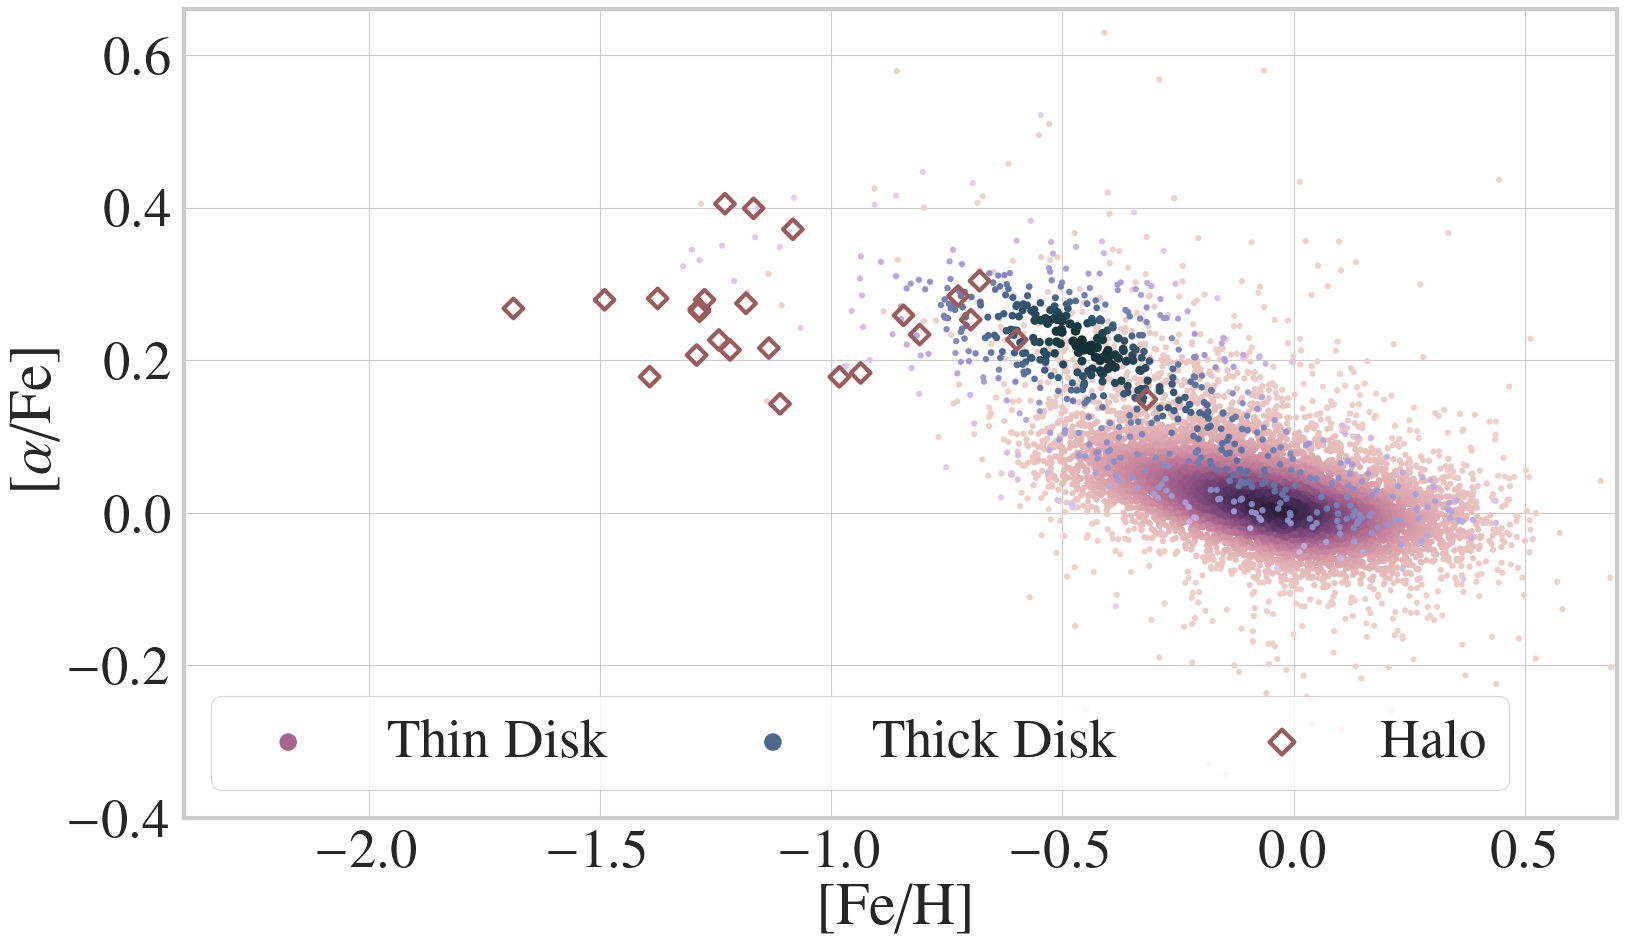

In [7]:
scaler = 0
for dataset, column in {
    "_apogee": "[alpha/M]_apogee",
    "_galah": "[alpha/Fe]_galah",
}.items():
    metallicity_alpha_plot, ax = plt.subplots()
    for i, component in enumerate(["Thin Disk", "Thick Disk"]):

        fit_data = data[data["Population"] == component]
        fit_data = fit_data[[f"[Fe/H]{dataset}", column]].dropna()
        kernel = gaussian_kde(fit_data.T)(fit_data.T)

        scatter_range = np.array([8, 20]) * (1.5 * scaler + 1)
        ax = sns.scatterplot(
            data=fit_data,
            x=f"[Fe/H]{dataset}",
            y=column,
            c=kernel,
            cmap=get_palette(as_cmap=True, start=2.3 * i),
            s=MinMaxScaler(feature_range=tuple(scatter_range)).fit_transform(  # type: ignore
                kernel.reshape(-1, 1) ** 4
            ),
            linewidth=0,
            rasterized=True,
            label=component,
            ax=ax,
        )

    sns.scatterplot(
        data=data[data["Population"] == "Halo"],
        x=f"[Fe/H]{dataset}",
        y=column,
        s=50 * (1 + scaler),
        marker="D",
        edgecolor=get_palette(start=0.4)[-3],  # type: ignore
        facecolor="none",
        linewidth=2 * (1 + 0.5 * scaler),
        rasterized=True,
        label="Halo",
        ax=ax,
    )
    adjust_legend(ax, ncols=3, loc="lower left", common_markersize=160)
    ax.set_xlabel("[Fe/H]")
    ax.set_ylabel(column.replace("alpha", r"$\alpha$").replace(dataset, ""))
    ax.set_xlim(-2.4, 0.7)
    ax.set_ylim(-0.4, 0.66)
    scaler += 1

    FigureProcessor(metallicity_alpha_plot).save(
        f"metallicity_alpha{dataset}.pdf",
        figure_directory=figure_directory,
        save=save,
    )
    plt.show()

## METALLICITY TABLES

In [11]:
data.groupby("Population").agg(
    {
        "[Fe/H]_apogee": ["median"],
        "[alpha/M]_apogee": ["median"],
        "[Fe/H]_galah": ["median"],
        "[alpha/Fe]_galah": ["median"],
    }
).round(2)

,[Fe/H]_apogee,[alpha/M]_apogee,[Fe/H]_galah,[alpha/Fe]_galah
,median,median,median,median
Population,,,,
Halo,-1.19,0.23,-1.17,0.26
Halo Candidate,-0.69,0.24,-0.77,0.26
Thick Disk,-0.37,0.17,-0.38,0.17
Thick Disk Candidate,-0.09,0.03,-0.10,0.03
Thin Disk,-0.03,0.00,-0.07,0.02
